# RL for continuous random walk problem

**Farzaneh Entezari** 

We want to implement $TD(\lambda)$ with accumulating traces for a continues random walk task.

In [ ]:
import numpy as np
import seaborn as sns
import bisect
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import time
import random
import matplotlib.pyplot as plt


In [ ]:
np.set_printoptions(precision=2)

## Set up the environment and tiling settings

Implementing sparse coarse coding and constructing binary features. We consider 10 different tiling settings each with a random offset.

In this task, a state, $s_{t}$, is defined as a point in the interval 0 to 1. This is an episodic task i.e, the episode ends when either state 0 or 1 is exceeded. The episode starts at state 0.5. At each step, the agent moves up or down by a uniformly selected random step in the interval [-0.2, 0.2].

The reward $r_{t}$ is 0 everywhere except when the agent terminates. When the agent terminates, the reward is equal to the termination state. For example, if agent terminates in a state -0.05, then it receives a reward of -0.05.

In [ ]:
class tile():

  def __init__ (self):
    offset= np.random.uniform(0,0.1) # randomly set the offset
    self.intervals = [ -offset ]
    for i in range (11) :  ## makes 11 intervals each of size 0.1
      self.intervals.append ( self.intervals[-1] + 0.1 )
    # stores 12 numbers which is start and end point of intervals

    self.intervals[0] =-2
    self.intervals[-1] =2

All_tilings={} ## store all different tilings in a dictionary
for x in range(10):  ## to obtain 10 different tilings
  All_tilings[x]=tile()


def StateToFeatures( state ):   ## builds table lookup features
  features = np.zeros((10,11))
  for j in range(len(All_tilings)):
    i = bisect.bisect_right(All_tilings[j].intervals , state) ## finds the interval given boundaries
    features [j , i-1] = 1  ## set the value one to the corresponding interval 
  features = np.mean(features , axis=0)
  return features




In [ ]:
class RandomWalk():

  def __init__(self): ## initializes the environment parameteres
    self.s0=0.5
    self.low =0 
    self.high =1
    self.gamma= 1
    self.reset()


  def reset(self): ## to reset the agent after each episode
    self.reward =0
    self.next_state= self.s0
    self.cur_state=self.s0
    self.terminate=False
    self.t=0
    self.E_trace = np.zeros(11)  ## reset the eligibilty trace
    self.trajectory= [self.s0]
    np.random.seed(random.randint(0,100)) ## change the random seed in each reset after each episode



  def choose_action(self): ## Random policy
    step = np.random.uniform(-0.2,0.2)  ## choose step uniformly in unit interval
    self.next_state = self.cur_state + step  ## observe the next state
    if self.next_state > self.high or self.next_state < self.low:
      self.reward= self.next_state ## observe the reward
      self.terminate=True
    return

  def take_action(self): ## move the agent
    self.t += 1
    self.cur_state = self.next_state
    self.trajectory.append(self.cur_state)
    return
    


agent=RandomWalk()



A sample of one full episode

In [ ]:
agent.reset()
while( not agent.terminate):
  agent.choose_action()
  agent.take_action()

agent.trajectory

[0.5,
 0.34602182655591157,
 0.3896484422677041,
 0.24300482794209943,
 0.13924067592823894,
 0.07009629825269484,
 0.2137512946321339,
 0.28018737987134423,
 0.29665226478470574,
 0.1082577945544499,
 0.20175711306656308,
 0.15973712043896543,
 0.280555967890432,
 0.18232441823438372,
 0.005078392894844436,
 0.15173784925452452,
 0.040149447608273034,
 0.0021452268271768965,
 -0.07141618476553964]

## Value function approximation

Implementing $TD(\lambda)$ with accumulating traces. Considering that the value function is a linear function of state features.

In [ ]:
## Define the value function and the gradiant of value function wrt w parameters.

def vhat(state , w ): ## consider linear function of state features.
  return state.T @ w # dot product

def nabla_vhat_w( state ): # the gradiant of vhat wrt w equals state 
  return state 
  

In [ ]:
class TD_lambda ():

  def update_Etrace (agent,lambd):  ## updates Eligibility trace after each step
    s_features = StateToFeatures(agent.cur_state) # convert agent's position to feature vector
    agent.E_trace = agent.gamma * lambd * agent.E_trace + s_features # decay eligibility of states and 1 to the current state
    return

  def error(agent , w):  ## compute TD error
    s_dash_features = StateToFeatures(agent.next_state) # convert agent's next position to feature vector
    s_features = StateToFeatures(agent.cur_state) # convert agent's cureent position to feature vector
    delta = agent.reward + agent.gamma * vhat( s_dash_features, w) - vhat( s_features , w) # compute the diffence between new estimated return and prevoiuse estimated value
    return delta
  

In [ ]:
def VFA(agent , alpha, lambd , epis_prog ): # if epis_prog=True, stores VF and RMS after each episode

  w = np.zeros(11) ## initialize VF parameters to zero ## predicts zero values at the beginning
  SE_prog=[]
  w_prog=[]

  for i in range(25) : ## run over 25 episodes

    agent.reset()  # it also resets the E trace

    while( not agent.terminate):
      agent.choose_action() ## choose action and observe S_next and R

      TD_lambda.update_Etrace(agent,lambd) ## update eligibility trace
      delta = TD_lambda.error(agent , w) ## compute TD error
      delta_w = alpha * delta * agent.E_trace 
      w = w +  delta_w ## update VF estimate

      agent.take_action()

    if (epis_prog): ## store w and error
      SE_prog.append ( VF_error(w) )
      w_prog.append( w )

  if (epis_prog):
    return w_prog , SE_prog
  else:
    return w


def VF_error(w):  ## compute RMS error for the estimated value function
  s = np.arange(21)/20
  v_true = s ## true state values are equal to positions
  v_estimate= np.zeros(v_true.shape)
  for i in range(len(s)):
    x = StateToFeatures(s[i])
    v_estimate[i] = vhat(x , w)
  return np.sqrt(np.mean(np.square( v_estimate - v_true )))






In [ ]:
w = VFA(agent, 0.3 , 0.2 , epis_prog=False) # predict VF for the random policy 
print(w)
VF_error(w)

[-0.16 -0.16 -0.07  0.04  0.12  0.17  0.22  0.72  1.06  1.16  1.24]


0.26208946392010546

##Plot the improvement in predicting the value function over 25 episodes

for $\alpha = 0.1$ and $\lambda=0.2$

In [ ]:
w_prog , SE_prog = VFA(agent, 0.1 , 0.2 , epis_prog=True)

Text(0, 0.5, 'RMS')

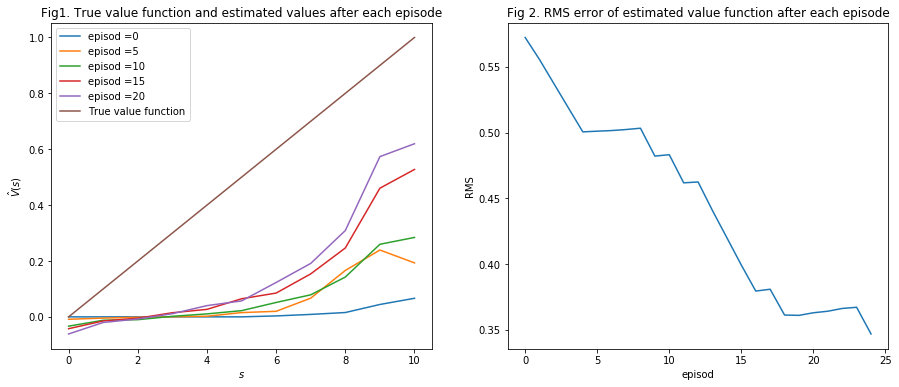

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

for i in range(0,len(w_prog),5):
  ax1.plot(w_prog[i] , label='episod =' + str(i) )
ax1.plot(np.arange(11) / 10 , label='True value function')
ax1.legend(loc="upper left")
ax1.set_title("Fig1. True value function and estimated values after each episode")
ax1.set_xlabel("$s$")
ax1.set_ylabel("$\hat{V}(s)$")

ax2.plot(SE_prog)
ax2.set_title('Fig 2. RMS error of estimated value function after each episode')
ax2.set_xlabel("episod")
ax2.set_ylabel("RMS")


##Linear value function approximationn for different values of learning rate and decay factor.



In [ ]:
alphas = np.arange(0,5) / 10 
lambdas = np.arange(0,10) / 10

RMS = []

with tqdm(total= len(lambdas) * len(alphas)) as pbar:
  for i in range(len(lambdas))  :
    for j in range(len(alphas)):
      lambd = lambdas[i]
      alpha = alphas[j]

      for k in range (50):  ## run VFA over 50 different seeds ## seeds are changed when the agent resets
        w = VFA (agent , alpha , lambd  , epis_prog=False) ## predict w parameters
        er = VF_error (w) ## compute RMS error

        res = dict(alpha=alpha, lambd='$\lambda= $' + str(lambd), RMS=er)
        RMS.append(res)  ## store the output for each run
      
      pbar.update(1)

RMS = pd.DataFrame(RMS, columns=['alpha' ,'lambd' , 'RMS'])

    

Text(0.5, 1.0, 'Fig 3. Effect of learning rate and decay factor on RMS error after 25 episodes, averaged over 50 runs.')

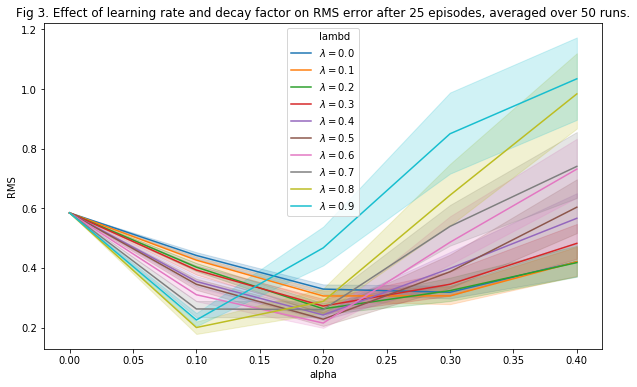

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data = RMS , x= 'alpha' , y='RMS' , hue= 'lambd', err_style = 'band' , dashes=False)
plt.title("Fig 3. Effect of learning rate and decay factor on RMS error after 25 episodes, averaged over 50 runs.")


## Observations

We implemented a backward view $TD(\lambda)$ where at each state, we update each prior state according to the TD error and eligibility trace. The eligibility trace keeps track of how much that state contributed to reaching to current state and how far was our visit to that state. So we update the states that are visited most recently, with higher factor.

Figure 1. shows how our estimation of value function, $\hat{v}(s)$, gets closer to the true value function, $v(s)$, over multiple runs of episodes. Figure 2. also shows the decrease in RMS error of the estimation of value function.

Figure 3. demonstrats the effect of different decay factors and learning rates. The blue curve which corresponds to $\lambda =0 $, known as $TD(0)$, is the case when we only update the last previous state at each step. 

The best combination of parameters in our environment is $\alpha = 0.1$ and $\lambda = 0.8 $ which gives 0.2 RMS error. 

The parameter $\lambda$ is the decay factor which is used to weight prevoius  steps proportionally in $TD(\lambda)$ target. When $\lambda =0 $, we have one step TD, and when $\lambda = 1$ we get Monte Carlo algorithm.  It can be seen that larger values of $\lambda$ results in higher variance, as for $\lambda =0 $ we see the least amount variance.

The parameter $\alpha$ is the learning rate which controls how much to change the model in response to the estimated error at each step. Large values of $\alpha$ causes higher error and variance, as it arrives on a sub-optimal set of weights.